This notebook is my final attempt at measuring how much of a difference a wall makes to the directionality of a microphone. 
I used 3 different microphones to test this (SMP1, SMP7, GRAS 1/4"). Each of the mics were recorded at 0,30,60,90deg off-axis, with and without a wall. The GRAS mic was also recorded 'flush' to the wall, and protruding by 1.7cm. 

The speaker was at ~2.1 m to avoid directionality effects. 


<img src="imgs/calibration_imgs/IMG_9561.JPG" width="400">
GRAS mic without wall (picture has grid, but all recordings done without grid)


<img src="imgs/calibration_imgs/IMG_9568.JPG" width="200">
Knowles SPU0410 mics recorded without wall. 

<img src="imgs/calibration_imgs/IMG_9572.JPG" width="400"> 
GRAS mic flush with wall 

<img src="imgs/calibration_imgs/IMG_9574.JPG" width="400"> 
Knowles mics flush with wall (also including speaker )

<img src="imgs/calibration_imgs/IMG_9576.JPG" width="400"> 
Knowles mics flush with wall




In [1]:
import datetime as dt
import glob
import os
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
import numpy as np 
import pandas as pd
import soundfile as sf
import scipy.signal as signal 
import tqdm
from playback_code import playback_analysis as pa
from fullscale_calculations import *

In [2]:
print(f'This cell was run at: {dt.datetime.now()}')

This cell was run at: 2021-05-07 14:33:52.823651


In [3]:
def get_loudest_part(X, fs=192000, winsize=0.025):
    x_sq = np.sqrt(np.abs(X)**2)
    winsamples = int(fs*winsize)
    running_mean = np.convolve(x_sq, np.ones(winsamples)/winsamples, mode='same')
    threshold = np.percentile(running_mean, [10,90])
    indices = np.logical_and(running_mean >=threshold[0], running_mean>=threshold[1])
    return indices, running_mean


In [4]:
def calculate_tones_rec_level(audio, fs, tone_freqs, FS_dbu, gain, sensitivity_dbvrms, freq_bw=500):
    '''
    '''
    
    audio_parts = np.array_split(audio, len(tone_freqs))
    
    tones_rms = []
    for peak_freq, tone_part in zip(tone_freqs, audio_parts):
        loudest_inds, _ = get_loudest_part(tone_part, fs=fs)
        audio_part = tone_part[loudest_inds]
        signal_fft = np.fft.fft(audio_part)
        fftfreqs = np.fft.fftfreq(audio_part.size, 1/fs)
        if np.logical_or(peak_freq<=0, peak_freq>=fs*0.5):
            raise ValueError(f'A peakfrequency <0 or > Nyquist frequency ({peak_freq}Hz) has been detected. Aborting....')
        signal_band = np.array([peak_freq-freq_bw, peak_freq+freq_bw])
        signal_band[signal_band<0] = 0
        signal_band[signal_band>fs*0.5] = fs*0.5
        rms_value = pa.extract_bandrms_from_fft(signal_band, signal_fft, fftfreqs)
        tones_rms.append(rms_value)
    
    #tones_rms = pa.get_tones_rms(audio, tone_freqs,fs=fs,bandwidth=freq_bw)
    tones_rms = pd.DataFrame(data={'tone_rms':tones_rms})
    max_rms = 1/(np.sqrt(2)) # for Vp=1 Vrms = (1/sqrt(2))*Vp
    tones_rms['dbrms_re_max'] = pa.dB(tones_rms['tone_rms']/max_rms)
    tones_rms['dbrms_wogain'] = tones_rms['dbrms_re_max']-gain
    tones_rms['db_FS'] = pa.dB(dbu2vrms(FS_dbu))
    tones_rms['tone_db'] = tones_rms['db_FS'] + tones_rms['dbrms_wogain']
    tones_rms['tone_freqs'] = tone_freqs
    sensitivity_vrms = 10**(sensitivity_dbvrms/20.0) # Vrms/Pa
    ref = 20*10**-6 # Pa

    tones_rms['Pa_rms'] = 10**(tones_rms['tone_db']/20.0)*(1/sensitivity_vrms)
    tones_rms['dbspl_rms'] = pa.dB(tones_rms['Pa_rms']/ref)
    return tones_rms

In [5]:
%matplotlib notebook

### How stable is the speaker playback

In [6]:
on_axis_gras = glob.glob('2021-05-06/gras-*_angle_0*.wav')
on_axis_gras

['2021-05-06\\gras-2mwall-flush_gaindB_70_azimuth_angle_0_2021-05-06_14-51-44.wav',
 '2021-05-06\\gras-2mwall-flush_gaindB_70_azimuth_angle_0_2021-05-06_14-52-10.wav',
 '2021-05-06\\gras-2mwall-flush_gaindB_70_azimuth_angle_0_2021-05-06_14-54-36.wav',
 '2021-05-06\\gras-2mwall-flush_gaindB_70_azimuth_angle_0_2021-05-06_14-55-00.wav',
 '2021-05-06\\gras-2mwall-flush_gaindB_70_azimuth_angle_0_2021-05-06_15-21-07.wav',
 '2021-05-06\\gras-2mwall-flush_gaindB_70_azimuth_angle_0_2021-05-06_15-23-10.wav',
 '2021-05-06\\gras-2mwall-notflush170mm_gaindB_76_azimuth_angle_0_2021-05-06_14-57-30.wav',
 '2021-05-06\\gras-2mwall-notflush170mm_gaindB_76_azimuth_angle_0_2021-05-06_14-57-56.wav',
 '2021-05-06\\gras-2mwall-notflush170mm_gaindB_76_azimuth_angle_0_2021-05-06_15-00-17.wav',
 '2021-05-06\\gras-2m_gaindB_70_azimuth_angle_0_2021-05-06_14-38-30.wav',
 '2021-05-06\\gras-2m_gaindB_70_azimuth_angle_0_2021-05-06_14-41-56.wav',
 '2021-05-06\\gras-2m_gaindB_70_azimuth_angle_0_2021-05-06_14-42-47.wav'

In [7]:
def extract_time_and_ttmt(fname):    
    parts = os.path.split(fname)[-1].split('_')
    return parts[0]+'_'+parts[-1]
unique_onaxis  = [extract_time_and_ttmt(each) for each in on_axis_gras]

In [20]:
fireface_dbu_FS = 27
gras_dbVrmsPa = -49.17
gras_gain = 70
gras_datasheet_freqs = np.arange(20,90,5)*10**3

In [21]:
freqs = np.arange(10000, 95000, 1000)
all_rec_data = []
onaxis_data = []
for identifier, filename in tqdm.tqdm(zip(unique_onaxis, on_axis_gras)):
    audio, fs = sf.read(filename)
    tones = pa.get_only_tones(audio, 1.5)
    b,a = signal.butter(2, np.array([9000,95500])/(fs*0.5), 'bandpass')
    tones_bp = signal.lfilter(b,a,tones)

    tones_parts = np.array_split(tones_bp, 85)
    tones_level = calculate_tones_rec_level(tones_bp, fs, freqs, fireface_dbu_FS, gras_gain, gras_dbVrmsPa,freq_bw=250)
    relevant_rows = np.flatnonzero(np.isin(tones_level['tone_freqs'].to_numpy(),gras_datasheet_freqs))
    tones_data_subs = tones_level.loc[relevant_rows,['tone_freqs','dbspl_rms']]
    tones_data_subs['identifier'] = identifier
    onaxis_data.append(tones_data_subs)
    all_rec_data.append(tones_level)

12it [00:53,  4.46s/it]


In [11]:
onaxis_gras = pd.concat(onaxis_data)

In [13]:
linetypes = ['k*','r*','g*']

In [14]:
onaxis_gras['recgroup'] = onaxis_gras['identifier'].apply(lambda X: X.split('_')[0])

<IPython.core.display.Javascript object>


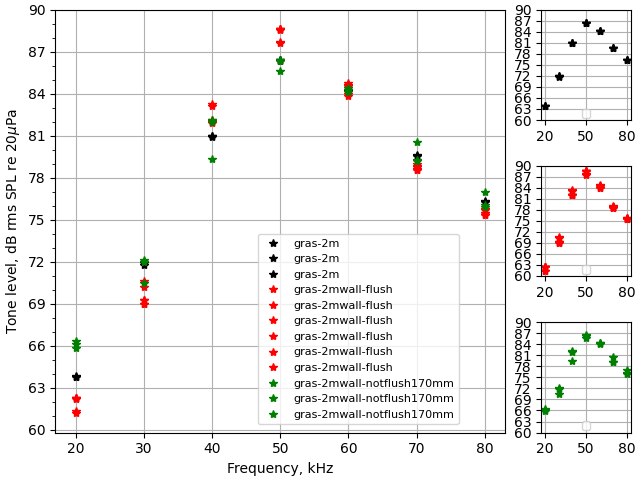

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


([<matplotlib.axis.XTick at 0x22f4a9334f0>,
 [Text(20000, 0, '20'), Text(50000, 0, '50'), Text(80000, 0, '80')])

In [19]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
fig = plt.figure(constrained_layout=True)

gs = GridSpec(6, 6, figure=fig)

main = fig.add_subplot(gs[:, :5])

for ttmt, df in onaxis_gras.groupby('identifier'):
    if '-2m_' in ttmt:
        linecol = linetypes[0]
    elif '-2mwall-flush' in ttmt:
        linecol = linetypes[1]
    else:
        linecol = linetypes[2]
    plt.plot(df['tone_freqs'], df['dbspl_rms'],linecol, label=ttmt.split('_')[0])
plt.legend(loc=(0.45, 0.02), fontsize=8)
plt.grid();plt.yticks(np.arange(60,92,3));
plt.xticks(gras_datasheet_freqs,np.arange(20,90,10));plt.ylabel('Tone level, dB rms SPL re 20$\mu$Pa')
plt.xlabel('Frequency, kHz')

nowall = fig.add_subplot(gs[:2, 5:])
nowall_msmts = onaxis_gras[onaxis_gras['recgroup'] == 'gras-2m']
plt.plot(nowall_msmts['tone_freqs'], nowall_msmts['dbspl_rms'],linetypes[0])
plt.legend(loc=(0.45, 0.02), fontsize=8)
plt.grid();plt.yticks(np.arange(60,92,3));plt.xticks([20000,50000, 80000],[20,50,80])
main.yaxis.set_minor_locator(MultipleLocator(1))

wallflush = fig.add_subplot(gs[2:4, 5:])
wallflush_msmts = onaxis_gras[onaxis_gras['recgroup'] == 'gras-2mwall-flush']
plt.plot(wallflush_msmts['tone_freqs'], wallflush_msmts['dbspl_rms'],linetypes[1])
plt.legend(loc=(0.45, 0.02), fontsize=8)
plt.grid();plt.yticks(np.arange(60,92,3));plt.xticks([20000,50000, 80000],[20,50,80])



notwallflush = fig.add_subplot(gs[4:, 5:])
notwallflush_msmts = onaxis_gras[onaxis_gras['recgroup'] == 'gras-2mwall-notflush170mm']
plt.plot(notwallflush_msmts['tone_freqs'], notwallflush_msmts['dbspl_rms'],linetypes[2])
plt.legend(loc=(0.45, 0.02), fontsize=8)
plt.grid();plt.yticks(np.arange(60,92,3));plt.xticks([20000,50000, 80000],[20,50,80])



## *Speaker variability still remains an issue!!!!* 
Here I'm only looking at a subset of frequencies - and already at 40 kHz (not flush with wall) there's a difference of ~ 3 dB in the source levels!!! This is despite not changing anything. 